In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset,DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


Load the Dataset

'/home/mich02/Desktop'

In [2]:
root = os.path.join(os.path.dirname(os.getcwd()), 'UMKC_DS_Capstone/archive/main')

# Define image transformations (resize, convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet values, might be useful to pre-trained ResNet
])

# Load the dataset
dataset = datasets.ImageFolder(root= root, transform=transform) #Automatically assigns labels based on folder names

# Create a DataLoader for batching
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Check the classes in the dataset
print("Classes:", dataset.classes)

# Example: Iterate over the DataLoader to check batch shapes
for images, labels in dataloader:
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    break

Classes: ['noStroke_data', 'stroke_data']
Image batch shape: torch.Size([32, 3, 256, 256])
Label batch shape: torch.Size([32])


Concatenate into 1 tensor

In [4]:
# Create empty lists to store images and labels
all_images = []
all_labels = []

# Loop through the DataLoader and gather all images and labels
for images, labels in dataloader:
    all_images.append(images)
    all_labels.append(labels)

# Concatenate the list of tensors into a single tensor
combined_images = torch.cat(all_images, dim=0)
combined_labels = torch.cat(all_labels, dim=0)

# Print the shape of the combined tensors
print("Combined image tensor shape:", combined_images.shape)
print("Combined label tensor shape:", combined_labels.shape)


Combined image tensor shape: torch.Size([3770, 3, 256, 256])
Combined label tensor shape: torch.Size([3770])


Train, validation and test split

In [5]:
# Define a batch size
batch_size = 16

# Total number of images
total_images = len(combined_images)

# Define split sizes
train_size = int(0.7 * total_images)   # 70% for training
val_size = int(0.15 * total_images)    # 15% for validation
test_size = total_images - train_size - val_size  # Remaining for test

# Split the dataset
train_data, val_data, test_data = random_split(list(zip(combined_images, combined_labels)), [train_size, val_size, test_size])

# Optional: Check the sizes of the splits
print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

# Create DataLoader for each split
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Check an example batch from the training set
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

Train set size: 2639
Validation set size: 565
Test set size: 566
torch.Size([16, 3, 256, 256]) torch.Size([16])


Print random image from the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5075778..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47408962..1.4960184].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7067103].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5178571..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49159664..1.7154248].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46533608..1.5045809].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.62

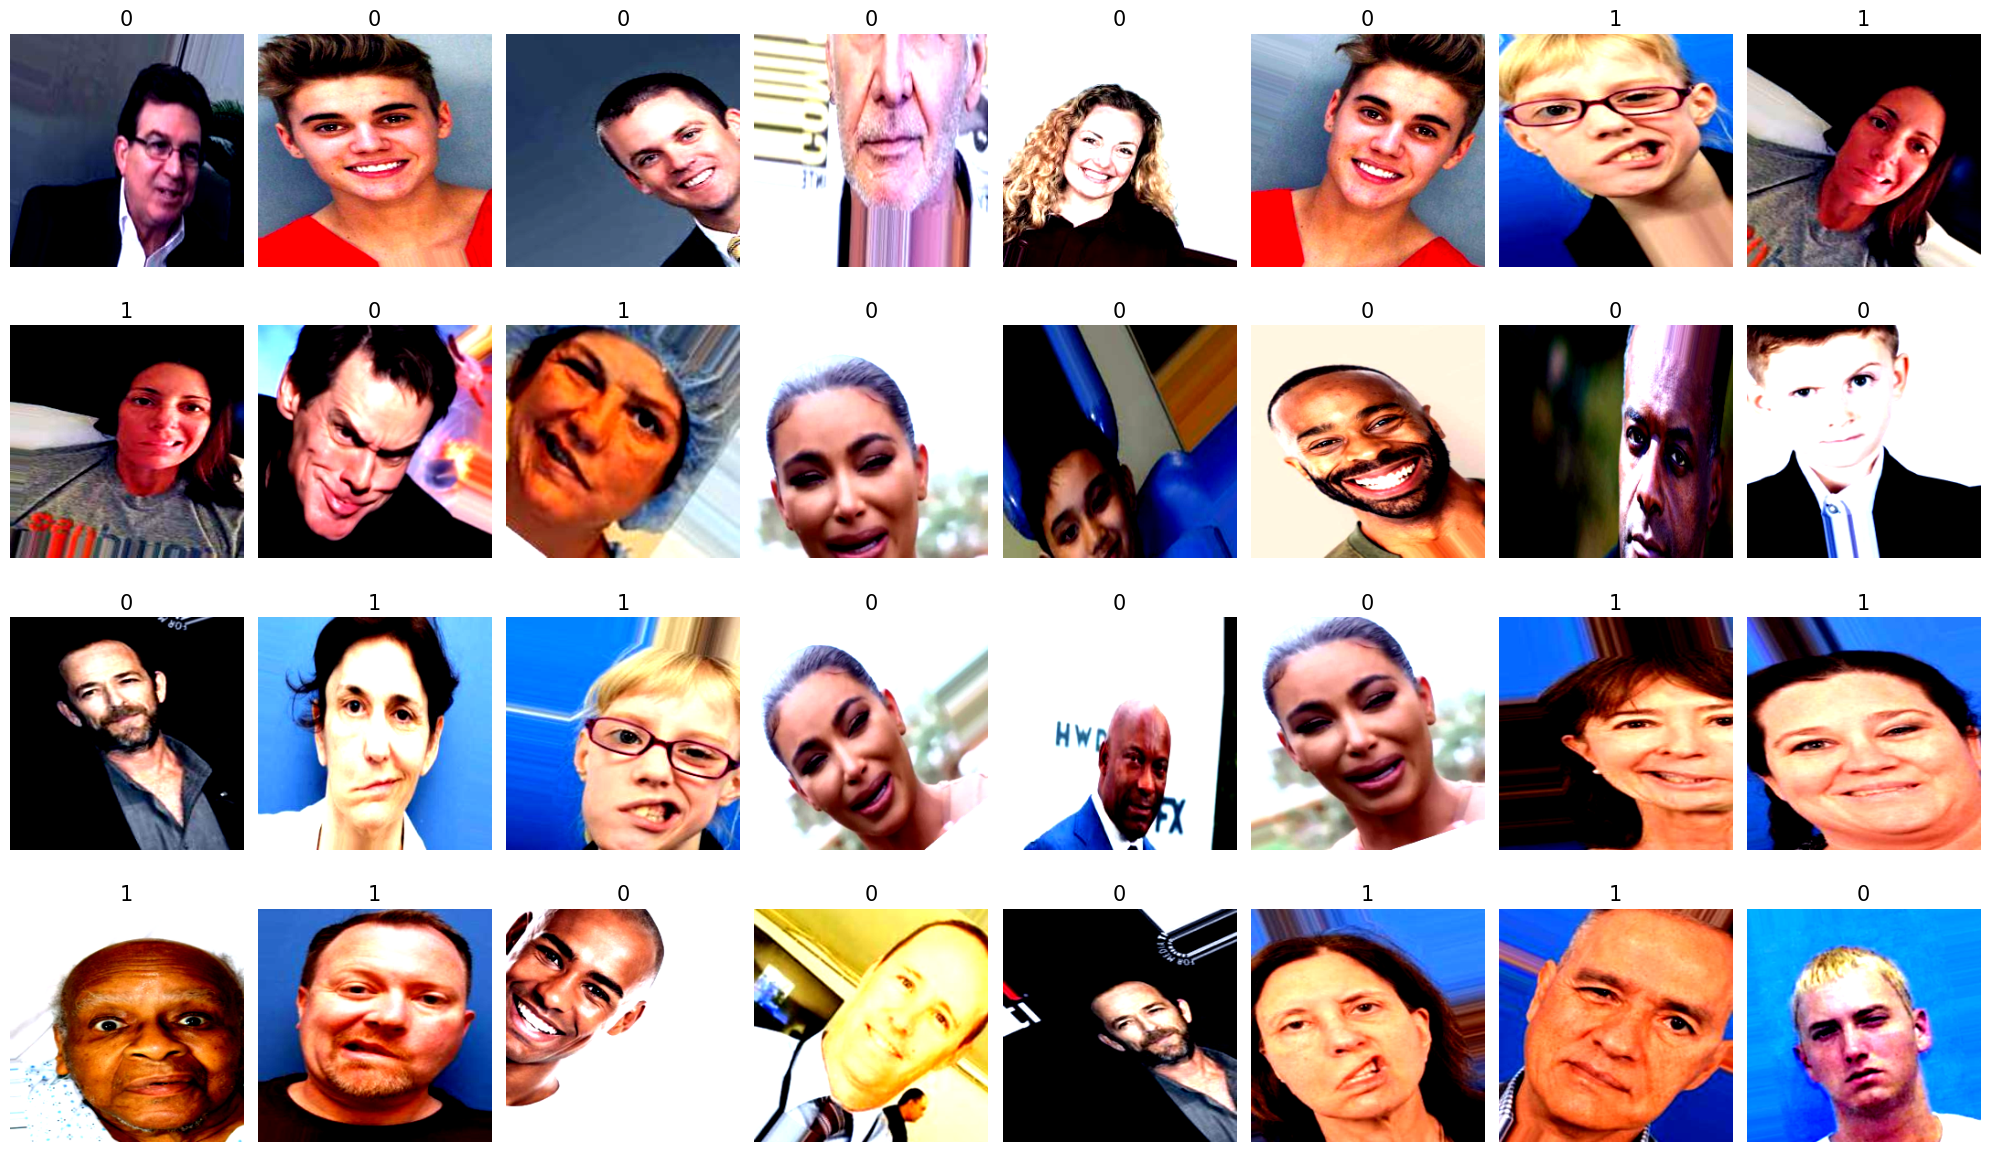

In [6]:
# Function to unnormalize and convert tensor image to numpy for plotting
def imshow(img):
    # Unnormalize: if you applied normalization before, reverse it here
    img = img / 2 + 0.5  # Assuming the image was normalized (this step can change based on your normalization)
    np_img = img.numpy()  # Convert tensor to numpy
    np_img = np.transpose(np_img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    return np_img

# Create a figure with 4x8 subplots
fig, axes = plt.subplots(4, 8, figsize=(20, 12))
axes = axes.flatten()

# Set a seed for reproducibility and select random 32 indices from the training set
np.random.seed(42)
idx = np.random.choice(len(train_data), size=32, replace=False)

# Loop over the selected indices and plot the images with titles
for i, ix in enumerate(idx):
    axes[i].axis('off')  # Hide axes ticks
    image, label = train_data[ix]  # Get the image and label from the train dataset
    axes[i].imshow(imshow(image))  # Plot the unnormalized image
    axes[i].set_title(str(int(label)), color='black', fontsize=15)  # Set title as label (stroke/no stroke)

# Display the plot
plt.tight_layout()
plt.show()

Set up the ResNet50

In [7]:
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck

class MyResNet (ResNet):
    def __init__(self, 
                 block = BasicBlock,
                 layers = [2, 2, 2, 2],
                 num_classes = 2):
        super(MyResNet, self).__init__(block,
                                       layers,
                                       num_classes = num_classes)
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 7, stride = 1, padding = 3, bias = False)
        
        '''
        you can modify the layers in this initialization of ResNet if you like
        '''
        
#Choose 1
resnet18 = {
    'block': BasicBlock,
    'layers': [2, 2, 2, 2]
}

resnet34 = {
    'block': BasicBlock,
    'layers': [3, 4, 6, 3]
}

resnet50 = {
    'block' : Bottleneck,
    'layers' : [3, 4, 6, 3]
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MyResNet(**resnet50).to(device)

In [12]:
%pip install torchinfo -q
import torchinfo

Note: you may need to restart the kernel to use updated packages.


Summary of the model

In [14]:
from torchinfo import summary # similiar function to tensorflow/keras summary for torch
summary(model, input_size = (batch_size, 3, 28, 28), device = 'cpu') # (color_channel, 28, 28)

Layer (type:depth-idx)                   Output Shape              Param #
MyResNet                                 [16, 2]                   --
├─Conv2d: 1-1                            [16, 64, 28, 28]          9,408
├─BatchNorm2d: 1-2                       [16, 64, 28, 28]          128
├─ReLU: 1-3                              [16, 64, 28, 28]          --
├─MaxPool2d: 1-4                         [16, 64, 14, 14]          --
├─Sequential: 1-5                        [16, 256, 14, 14]         --
│    └─Bottleneck: 2-1                   [16, 256, 14, 14]         --
│    │    └─Conv2d: 3-1                  [16, 64, 14, 14]          4,096
│    │    └─BatchNorm2d: 3-2             [16, 64, 14, 14]          128
│    │    └─ReLU: 3-3                    [16, 64, 14, 14]          --
│    │    └─Conv2d: 3-4                  [16, 64, 14, 14]          36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 14, 14]          128
│    │    └─ReLU: 3-6                    [16, 64, 14, 14]          --
│ 

Move to GPU

In [10]:
print("Is GPU available: ", torch.cuda.is_available())

Is GPU available:  True


Set up the training with optimizer

In [17]:
# Use AdamW optimizer
learning_rate = 1e-3
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 30
acc_last_epoch = 0.0
acc_max = 0.0

Train and validate

In [15]:
#Move to GPU
model.to(device)


MyResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

In [16]:
from tqdm.auto import tqdm


# Training loop with tqdm progress bar
for epoch in range(epochs):
    model.train()
    
    # Initialize the progress bar for training
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for x, targets in train_loader:
            # Move inputs and targets to the GPU
            x, targets = x.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(x)
            loss = loss_func(outputs, targets)
            
            # Backward pass and optimizer step
            optimizer.zero_grad()  # Clear the gradients
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the weights
            
            # Update the progress bar description with the current loss
            pbar.set_postfix(loss=loss.item())
            pbar.update()  # Update the progress bar after each batch

    # Validation loop with tqdm progress bar
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():  # Disable gradient calculation
        with tqdm(total=len(val_loader), desc=f'Validation Epoch {epoch+1}/{epochs}', unit='batch') as pbar_val:
            for x_v, y_v in val_loader:
                # Move validation data to the GPU
                x_v, y_v = x_v.to(device), y_v.to(device)
                yhat = model(x_v)
                yhat = yhat.argmax(dim=-1)

                # Calculate validation loss and accuracy
                val_loss += loss_func(model(x_v), y_v).item()
                val_acc += (yhat == y_v).float().mean().item()

                # Update the progress bar for validation
                pbar_val.update()

    # Average the validation loss and accuracy
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    print(f'Epoch {epoch+1}/{epochs} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

Validation Epoch 1/100: 100%|██████████| 36/36 [00:05<00:00,  6.80batch/s]


Epoch 1/100 - Validation Loss: 0.3044, Validation Accuracy: 0.8819


Validation Epoch 2/100: 100%|██████████| 36/36 [00:05<00:00,  6.38batch/s]


Epoch 2/100 - Validation Loss: 0.1692, Validation Accuracy: 0.9497


Validation Epoch 3/100: 100%|██████████| 36/36 [00:05<00:00,  6.03batch/s]


Epoch 3/100 - Validation Loss: 0.1067, Validation Accuracy: 0.9653


Validation Epoch 4/100: 100%|██████████| 36/36 [00:06<00:00,  5.38batch/s]


Epoch 4/100 - Validation Loss: 0.1099, Validation Accuracy: 0.9375


Validation Epoch 5/100: 100%|██████████| 36/36 [00:05<00:00,  6.83batch/s]


Epoch 5/100 - Validation Loss: 0.0871, Validation Accuracy: 0.9618


Validation Epoch 6/100: 100%|██████████| 36/36 [00:05<00:00,  6.65batch/s]


Epoch 6/100 - Validation Loss: 0.1198, Validation Accuracy: 0.9635


Validation Epoch 7/100: 100%|██████████| 36/36 [00:05<00:00,  6.59batch/s]


Epoch 7/100 - Validation Loss: 0.0382, Validation Accuracy: 0.9878


Validation Epoch 8/100: 100%|██████████| 36/36 [00:05<00:00,  6.48batch/s]


Epoch 8/100 - Validation Loss: 0.0917, Validation Accuracy: 0.9583


Validation Epoch 9/100: 100%|██████████| 36/36 [00:04<00:00,  7.88batch/s]


Epoch 9/100 - Validation Loss: 0.0891, Validation Accuracy: 0.9618


Validation Epoch 10/100: 100%|██████████| 36/36 [00:04<00:00,  7.76batch/s]


Epoch 10/100 - Validation Loss: 0.4336, Validation Accuracy: 0.9757


Validation Epoch 11/100: 100%|██████████| 36/36 [00:04<00:00,  7.81batch/s]


Epoch 11/100 - Validation Loss: 0.0530, Validation Accuracy: 0.9896


Validation Epoch 12/100: 100%|██████████| 36/36 [00:04<00:00,  7.75batch/s]


Epoch 12/100 - Validation Loss: 0.0374, Validation Accuracy: 0.9931


Validation Epoch 13/100: 100%|██████████| 36/36 [00:04<00:00,  7.83batch/s]


Epoch 13/100 - Validation Loss: 0.0453, Validation Accuracy: 0.9896


Validation Epoch 14/100: 100%|██████████| 36/36 [00:04<00:00,  7.75batch/s]


Epoch 14/100 - Validation Loss: 0.0257, Validation Accuracy: 0.9913


Validation Epoch 15/100: 100%|██████████| 36/36 [00:04<00:00,  7.70batch/s]


Epoch 15/100 - Validation Loss: 0.0046, Validation Accuracy: 1.0000


Validation Epoch 16/100: 100%|██████████| 36/36 [00:04<00:00,  7.67batch/s]


Epoch 16/100 - Validation Loss: 0.0447, Validation Accuracy: 0.9896


Validation Epoch 17/100: 100%|██████████| 36/36 [00:04<00:00,  7.64batch/s]


Epoch 17/100 - Validation Loss: 0.0112, Validation Accuracy: 1.0000


Validation Epoch 18/100: 100%|██████████| 36/36 [00:04<00:00,  7.78batch/s]


Epoch 18/100 - Validation Loss: 0.0395, Validation Accuracy: 0.9878


Validation Epoch 19/100: 100%|██████████| 36/36 [00:04<00:00,  7.88batch/s]


Epoch 19/100 - Validation Loss: 0.0113, Validation Accuracy: 0.9983


Validation Epoch 20/100: 100%|██████████| 36/36 [00:04<00:00,  8.13batch/s]


Epoch 20/100 - Validation Loss: 0.0225, Validation Accuracy: 0.9931


Validation Epoch 21/100: 100%|██████████| 36/36 [00:03<00:00,  9.40batch/s]


Epoch 21/100 - Validation Loss: 0.5117, Validation Accuracy: 0.9024


Validation Epoch 22/100: 100%|██████████| 36/36 [00:03<00:00,  9.40batch/s]


Epoch 22/100 - Validation Loss: 0.0071, Validation Accuracy: 1.0000


Validation Epoch 23/100: 100%|██████████| 36/36 [00:03<00:00,  9.40batch/s]


Epoch 23/100 - Validation Loss: 0.1069, Validation Accuracy: 0.9635


Validation Epoch 24/100: 100%|██████████| 36/36 [00:03<00:00,  9.40batch/s]


Epoch 24/100 - Validation Loss: 0.0029, Validation Accuracy: 1.0000


Validation Epoch 25/100: 100%|██████████| 36/36 [00:04<00:00,  8.33batch/s]


Epoch 25/100 - Validation Loss: 0.0032, Validation Accuracy: 1.0000


Validation Epoch 26/100: 100%|██████████| 36/36 [00:03<00:00,  9.41batch/s]


Epoch 26/100 - Validation Loss: 0.0051, Validation Accuracy: 1.0000


Validation Epoch 27/100: 100%|██████████| 36/36 [00:03<00:00,  9.40batch/s]


Epoch 27/100 - Validation Loss: 0.0022, Validation Accuracy: 1.0000


Validation Epoch 28/100: 100%|██████████| 36/36 [00:03<00:00,  9.40batch/s]


Epoch 28/100 - Validation Loss: 1.3401, Validation Accuracy: 0.8924


Validation Epoch 29/100: 100%|██████████| 36/36 [00:03<00:00,  9.40batch/s]


Epoch 29/100 - Validation Loss: 0.0188, Validation Accuracy: 0.9931


Validation Epoch 30/100: 100%|██████████| 36/36 [00:03<00:00,  9.39batch/s]


Epoch 30/100 - Validation Loss: 0.0069, Validation Accuracy: 0.9965


Validation Epoch 31/100: 100%|██████████| 36/36 [00:04<00:00,  8.02batch/s]


Epoch 31/100 - Validation Loss: 0.0038, Validation Accuracy: 1.0000


Validation Epoch 32/100: 100%|██████████| 36/36 [00:04<00:00,  7.72batch/s]


Epoch 32/100 - Validation Loss: 0.0053, Validation Accuracy: 0.9983


Validation Epoch 33/100: 100%|██████████| 36/36 [00:04<00:00,  7.52batch/s]


Epoch 33/100 - Validation Loss: 0.0098, Validation Accuracy: 0.9983


Validation Epoch 34/100: 100%|██████████| 36/36 [00:04<00:00,  7.68batch/s]


Epoch 34/100 - Validation Loss: 0.0217, Validation Accuracy: 0.9948


Validation Epoch 35/100: 100%|██████████| 36/36 [00:04<00:00,  7.97batch/s]


Epoch 35/100 - Validation Loss: 0.0186, Validation Accuracy: 0.9948


Validation Epoch 36/100: 100%|██████████| 36/36 [00:04<00:00,  7.84batch/s]


Epoch 36/100 - Validation Loss: 0.0029, Validation Accuracy: 1.0000


Validation Epoch 37/100: 100%|██████████| 36/36 [00:04<00:00,  7.93batch/s]


Epoch 37/100 - Validation Loss: 0.0017, Validation Accuracy: 1.0000


Validation Epoch 38/100: 100%|██████████| 36/36 [00:04<00:00,  8.05batch/s]


Epoch 38/100 - Validation Loss: 0.0027, Validation Accuracy: 1.0000


Validation Epoch 39/100: 100%|██████████| 36/36 [00:04<00:00,  7.92batch/s]


Epoch 39/100 - Validation Loss: 0.0050, Validation Accuracy: 1.0000


Validation Epoch 40/100: 100%|██████████| 36/36 [00:04<00:00,  7.79batch/s]


Epoch 40/100 - Validation Loss: 0.5364, Validation Accuracy: 0.9389


Validation Epoch 41/100: 100%|██████████| 36/36 [00:04<00:00,  7.84batch/s]


Epoch 41/100 - Validation Loss: 0.0059, Validation Accuracy: 1.0000


Validation Epoch 42/100: 100%|██████████| 36/36 [00:04<00:00,  7.74batch/s]


Epoch 42/100 - Validation Loss: 0.0069, Validation Accuracy: 0.9983


Validation Epoch 43/100: 100%|██████████| 36/36 [00:03<00:00,  9.42batch/s]


Epoch 43/100 - Validation Loss: 0.0011, Validation Accuracy: 1.0000


Validation Epoch 44/100: 100%|██████████| 36/36 [00:03<00:00,  9.39batch/s]


Epoch 44/100 - Validation Loss: 0.0204, Validation Accuracy: 0.9948


Validation Epoch 45/100: 100%|██████████| 36/36 [00:03<00:00,  9.41batch/s]


Epoch 45/100 - Validation Loss: 0.0013, Validation Accuracy: 1.0000


Validation Epoch 46/100: 100%|██████████| 36/36 [00:03<00:00,  9.40batch/s]


Epoch 46/100 - Validation Loss: 0.0012, Validation Accuracy: 1.0000


Validation Epoch 47/100: 100%|██████████| 36/36 [00:03<00:00,  9.39batch/s]


Epoch 47/100 - Validation Loss: 0.0007, Validation Accuracy: 1.0000


Validation Epoch 48/100: 100%|██████████| 36/36 [00:03<00:00,  9.41batch/s]


Epoch 48/100 - Validation Loss: 0.0046, Validation Accuracy: 1.0000


Validation Epoch 49/100: 100%|██████████| 36/36 [00:03<00:00,  9.41batch/s]


Epoch 49/100 - Validation Loss: 0.0133, Validation Accuracy: 0.9931


Validation Epoch 50/100: 100%|██████████| 36/36 [00:03<00:00,  9.40batch/s]


Epoch 50/100 - Validation Loss: 0.0006, Validation Accuracy: 1.0000


Validation Epoch 51/100: 100%|██████████| 36/36 [00:03<00:00,  9.40batch/s]


Epoch 51/100 - Validation Loss: 0.0333, Validation Accuracy: 0.9896


Validation Epoch 52/100: 100%|██████████| 36/36 [00:03<00:00,  9.40batch/s]


Epoch 52/100 - Validation Loss: 0.0090, Validation Accuracy: 0.9965


Validation Epoch 53/100: 100%|██████████| 36/36 [00:03<00:00,  9.40batch/s]


Epoch 53/100 - Validation Loss: 0.0023, Validation Accuracy: 1.0000


Validation Epoch 54/100: 100%|██████████| 36/36 [00:03<00:00,  9.40batch/s]


Epoch 54/100 - Validation Loss: 0.0047, Validation Accuracy: 0.9983


Validation Epoch 55/100: 100%|██████████| 36/36 [00:03<00:00,  9.40batch/s]


Epoch 55/100 - Validation Loss: 0.0038, Validation Accuracy: 0.9983


Validation Epoch 56/100: 100%|██████████| 36/36 [00:03<00:00,  9.42batch/s]


Epoch 56/100 - Validation Loss: 0.0019, Validation Accuracy: 1.0000


Validation Epoch 57/100: 100%|██████████| 36/36 [00:03<00:00,  9.42batch/s]


Epoch 57/100 - Validation Loss: 0.0003, Validation Accuracy: 1.0000


Validation Epoch 58/100: 100%|██████████| 36/36 [00:03<00:00,  9.41batch/s]


Epoch 58/100 - Validation Loss: 0.0082, Validation Accuracy: 0.9965


Validation Epoch 59/100: 100%|██████████| 36/36 [00:03<00:00,  9.42batch/s]


Epoch 59/100 - Validation Loss: 0.0035, Validation Accuracy: 1.0000


Validation Epoch 60/100: 100%|██████████| 36/36 [00:03<00:00,  9.40batch/s]


Epoch 60/100 - Validation Loss: 0.0436, Validation Accuracy: 0.9861


Validation Epoch 61/100: 100%|██████████| 36/36 [00:03<00:00,  9.41batch/s]


Epoch 61/100 - Validation Loss: 0.0015, Validation Accuracy: 1.0000


Validation Epoch 62/100: 100%|██████████| 36/36 [00:03<00:00,  9.41batch/s]


Epoch 62/100 - Validation Loss: 0.0092, Validation Accuracy: 0.9965


Validation Epoch 63/100: 100%|██████████| 36/36 [00:03<00:00,  9.40batch/s]


Epoch 63/100 - Validation Loss: 0.0014, Validation Accuracy: 1.0000


Validation Epoch 64/100: 100%|██████████| 36/36 [00:03<00:00,  9.41batch/s]


Epoch 64/100 - Validation Loss: 0.0710, Validation Accuracy: 0.9722


Validation Epoch 65/100: 100%|██████████| 36/36 [00:03<00:00,  9.41batch/s]


Epoch 65/100 - Validation Loss: 0.0036, Validation Accuracy: 1.0000


Validation Epoch 66/100: 100%|██████████| 36/36 [00:03<00:00,  9.41batch/s]


Epoch 66/100 - Validation Loss: 0.0062, Validation Accuracy: 0.9965


Validation Epoch 67/100: 100%|██████████| 36/36 [00:03<00:00,  9.41batch/s]


Epoch 67/100 - Validation Loss: 0.0034, Validation Accuracy: 0.9983


Validation Epoch 68/100: 100%|██████████| 36/36 [00:03<00:00,  9.43batch/s]


Epoch 68/100 - Validation Loss: 0.0089, Validation Accuracy: 0.9983


Validation Epoch 69/100: 100%|██████████| 36/36 [00:04<00:00,  7.93batch/s]


Epoch 69/100 - Validation Loss: 0.0516, Validation Accuracy: 0.9913


Validation Epoch 70/100: 100%|██████████| 36/36 [00:04<00:00,  7.91batch/s]


Epoch 70/100 - Validation Loss: 0.0010, Validation Accuracy: 1.0000


Validation Epoch 71/100: 100%|██████████| 36/36 [00:04<00:00,  7.95batch/s]


Epoch 71/100 - Validation Loss: 0.0008, Validation Accuracy: 1.0000


Validation Epoch 72/100: 100%|██████████| 36/36 [00:04<00:00,  7.92batch/s]


Epoch 72/100 - Validation Loss: 0.0020, Validation Accuracy: 0.9983


Validation Epoch 73/100: 100%|██████████| 36/36 [00:04<00:00,  7.92batch/s]


Epoch 73/100 - Validation Loss: 0.0079, Validation Accuracy: 0.9983


Validation Epoch 74/100: 100%|██████████| 36/36 [00:04<00:00,  7.92batch/s]


Epoch 74/100 - Validation Loss: 0.0008, Validation Accuracy: 1.0000


Validation Epoch 75/100: 100%|██████████| 36/36 [00:04<00:00,  7.82batch/s]


Epoch 75/100 - Validation Loss: 0.0152, Validation Accuracy: 0.9948


Validation Epoch 76/100: 100%|██████████| 36/36 [00:04<00:00,  7.81batch/s]


Epoch 76/100 - Validation Loss: 0.0028, Validation Accuracy: 1.0000


Validation Epoch 77/100: 100%|██████████| 36/36 [00:04<00:00,  7.84batch/s]


Epoch 77/100 - Validation Loss: 0.0104, Validation Accuracy: 0.9948


Validation Epoch 78/100: 100%|██████████| 36/36 [00:03<00:00,  9.37batch/s]


Epoch 78/100 - Validation Loss: 0.0009, Validation Accuracy: 1.0000


Validation Epoch 79/100: 100%|██████████| 36/36 [00:03<00:00,  9.40batch/s]


Epoch 79/100 - Validation Loss: 0.0011, Validation Accuracy: 1.0000


Validation Epoch 80/100: 100%|██████████| 36/36 [00:03<00:00,  9.40batch/s]


Epoch 80/100 - Validation Loss: 0.0007, Validation Accuracy: 1.0000


Validation Epoch 81/100: 100%|██████████| 36/36 [00:03<00:00,  9.40batch/s]


Epoch 81/100 - Validation Loss: 0.0006, Validation Accuracy: 1.0000


Validation Epoch 82/100: 100%|██████████| 36/36 [00:03<00:00,  9.41batch/s]


Epoch 82/100 - Validation Loss: 0.0059, Validation Accuracy: 1.0000


Validation Epoch 83/100: 100%|██████████| 36/36 [00:03<00:00,  9.41batch/s]


Epoch 83/100 - Validation Loss: 0.0039, Validation Accuracy: 0.9983


Validation Epoch 84/100: 100%|██████████| 36/36 [00:03<00:00,  9.40batch/s]


Epoch 84/100 - Validation Loss: 0.0008, Validation Accuracy: 1.0000


Validation Epoch 85/100: 100%|██████████| 36/36 [00:03<00:00,  9.43batch/s]


Epoch 85/100 - Validation Loss: 0.0004, Validation Accuracy: 1.0000


Validation Epoch 86/100: 100%|██████████| 36/36 [00:03<00:00,  9.41batch/s]


Epoch 86/100 - Validation Loss: 0.0004, Validation Accuracy: 1.0000


Validation Epoch 87/100: 100%|██████████| 36/36 [00:03<00:00,  9.40batch/s]


Epoch 87/100 - Validation Loss: 0.0011, Validation Accuracy: 1.0000


Validation Epoch 88/100: 100%|██████████| 36/36 [00:03<00:00,  9.40batch/s]


Epoch 88/100 - Validation Loss: 0.0015, Validation Accuracy: 1.0000


Validation Epoch 89/100: 100%|██████████| 36/36 [00:03<00:00,  9.39batch/s]


Epoch 89/100 - Validation Loss: 0.0300, Validation Accuracy: 0.9913


Validation Epoch 90/100: 100%|██████████| 36/36 [00:03<00:00,  9.40batch/s]


Epoch 90/100 - Validation Loss: 0.0045, Validation Accuracy: 0.9983


Validation Epoch 91/100: 100%|██████████| 36/36 [00:04<00:00,  8.36batch/s]


Epoch 91/100 - Validation Loss: 0.0006, Validation Accuracy: 1.0000


Validation Epoch 92/100: 100%|██████████| 36/36 [00:04<00:00,  7.79batch/s]


Epoch 92/100 - Validation Loss: 0.0004, Validation Accuracy: 1.0000


Validation Epoch 93/100: 100%|██████████| 36/36 [00:04<00:00,  7.79batch/s]


Epoch 93/100 - Validation Loss: 0.0008, Validation Accuracy: 1.0000


Validation Epoch 94/100: 100%|██████████| 36/36 [00:04<00:00,  8.00batch/s]


Epoch 94/100 - Validation Loss: 0.0004, Validation Accuracy: 1.0000


Validation Epoch 95/100: 100%|██████████| 36/36 [00:04<00:00,  7.91batch/s]


Epoch 95/100 - Validation Loss: 0.0014, Validation Accuracy: 1.0000


Validation Epoch 96/100: 100%|██████████| 36/36 [00:04<00:00,  7.98batch/s]


Epoch 96/100 - Validation Loss: 0.0004, Validation Accuracy: 1.0000


Validation Epoch 97/100: 100%|██████████| 36/36 [00:04<00:00,  7.91batch/s]


Epoch 97/100 - Validation Loss: 0.0209, Validation Accuracy: 0.9913


Validation Epoch 98/100: 100%|██████████| 36/36 [00:04<00:00,  7.87batch/s]


Epoch 98/100 - Validation Loss: 0.0162, Validation Accuracy: 0.9948


Validation Epoch 99/100: 100%|██████████| 36/36 [00:04<00:00,  7.95batch/s]


Epoch 99/100 - Validation Loss: 0.0004, Validation Accuracy: 1.0000


Validation Epoch 100/100: 100%|██████████| 36/36 [00:03<00:00,  9.36batch/s]

Epoch 100/100 - Validation Loss: 0.0005, Validation Accuracy: 1.0000


Predict on the test dataset

In [25]:
import torch.nn.functional as F

y_preds = []
for x in tqdm(test_loader):
    with torch.no_grad():
        x = x[0].to(device)
        y_pred = model(x)  # Forward pass through the model
        y_pred = F.softmax(y_pred, dim=1)  # Convert logits to probabilities for binary classification
        y_preds.append(y_pred.cpu().detach().numpy())  # Collect predictions as numpy arrays

# Concatenate predictions into one array
y_preds = np.concatenate(y_preds)

# If using softmax, get the argmax to find the class (0 or 1)
preds = y_preds.argmax(axis=-1).astype(int)

print(preds.shape)  # Should match the number of test samples

100%|██████████| 36/36 [00:02<00:00, 14.91it/s]

(566,)


Test on existing image in google

In [58]:
root = os.path.join(os.path.expanduser("~"), 'Downloads/face_stroke_test5.jpg')

# Define the transformation pipeline (similar to the one used during training)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize image to match the input size of the model
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# Function to load and preprocess a single image
def predict_image(image_path, model):
    # Load the image
    image = Image.open(image_path).convert('RGB')
    
    # Apply the transformations to the image
    image = transform(image).unsqueeze(0)  # Add batch dimension (1, C, H, W)
    
    # Move the image to the same device as the model (CPU or GPU)
    image = image.to(device)
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        # Forward pass through the model
        output = model(image)
        
        # Apply softmax to convert logits to probabilities
        probabilities = F.softmax(output, dim=1)
        
        # Get the predicted class (0 or 1)
        predicted_class = probabilities.argmax(dim=1).item()

    # Return the predicted class (0 = no stroke, 1 = stroke)
    return predicted_class

# Example usage:
predicted_class = predict_image(image_path = root, model = model)

if predicted_class == 1:
    print("Prediction: Stroke")
else:
    print("Prediction: No Stroke")


Prediction: Stroke


# Citation 

Shuhao Cao. (2023). UMKC 2023 Fall CS 5590 / Math 5555 Optimization. Kaggle. https://kaggle.com/competitions/umkc-2023-fall-cs-5590-math-5555-optimization